## sklearn

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1,data_home=r'./')  # 14M.

print(mnist.keys())

print(mnist['data'].shape, mnist['target'].shape)   # 'data', 'target'모두 정수 numpy array(dtype없음)
print(mnist['data'].dtype, mnist['target'].dtype)

In [ ]:
mnist['data'].dtype, mnist['target'].dtype

In [ ]:
X = (mnist['data']/255).astype(np.float32)
Y = mnist['target'].astype(np.uint8)

In [ ]:
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i].reshape(28,28),cmap='gray')

## Tensorflow

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)

dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train[...,tf.newaxis]/255, tf.float32), tf.cast(y_train,tf.int32)))
dataset = dataset.shuffle(1000).batch(12)

In [ ]:
it = iter(dataset)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

In [ ]:
for x,y in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

## pytorch

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torch import nn
import numpy as np

In [ ]:
# 다운 받은 data는 PIL.Image.Image(np.array로 변환해 보면 shape(28,28) uint8)이다. transform을 통해 tensor로 변환해야 하다.
# (28,28)이기 때문에, reshape이 필요없다.

download_root = r'D:\hccho\CommonDataset\mnist'  #---> 아래에 MNIST- raw, processed 2개의 subdirectory가 생성된다. 

transform = transforms.Compose([transforms.ToTensor()]) # channel dim이 생성(1,28,28)

train_dataset = datasets.MNIST(download_root, transform=transform, train=True, download=True)   # transform을 넣어야 한다.
test_dataset = datasets.MNIST(download_root, transform=transform, train=False, download=True)

#train_dataset[0][0].show()  # PIL.Image.Image

print(len(train_dataset),len(test_dataset))   # 60000(1,28,28), 10000

train_loader = DataLoader(train_dataset,batch_size=12,shuffle=True)

In [ ]:
it = iter(train_loader)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i,0].numpy(),cmap='gray')

In [ ]:
x.shape

## Classification

- 결론을 말하면, FC layer만으로는 그림판으로 입력한 숫자를 판별하지 못하다.
- CNN으로 모델을 구성하면 잘 판별한다
- image를 만들때, (28,28)로 만들지 말고, (100,100)정도로 만들면 resize과정에서 mnist dataset과 유사해 진다.


In [10]:
download_root = r'D:\hccho\CommonDataset\mnist'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root=download_root, 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)   # ---> Dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_dataset = torchvision.datasets.MNIST(root=download_root, 
                                          train=False, 
                                          transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
print(type(train_dataset))
len(train_dataset), len(train_loader), len(test_dataset), len(test_loader)

torchvision.datasets.mnist.MNIST


(60000, 600, 10000, 100)

In [4]:
# https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4
# https://github.com/python-engineer/pytorch-examples
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.dropout = nn.Dropout(0.3)
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.dropout(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

# http://www.ccom.ucsd.edu/~cdeotte/programs/MNIST.html
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.pooling = nn.AvgPool1d(4)
        self.l1 = nn.Linear(196,100)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(100, num_classes)  
    
    def forward(self, x):
        out = torch.unsqueeze(x,1)
        out = self.pooling(out)
        out = torch.squeeze(out,1)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out


In [13]:
#model = NeuralNet(input_size, hidden_size, num_classes).to(device)
#model = NeuralNet2(input_size, hidden_size, num_classes).to(device)   # ===> 별 효과 없음.
model = CNN().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [14]:
# Train the model
model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        
        if type(model) is CNN:
            images = images.to(device)
        else:
            images = images.reshape(-1, 28*28).to(device)
        
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'mnist_model.pth')
print('model saved: ','mnist_model.pth')

Epoch [1/5], Step [100/600], Loss: 0.2003
Epoch [1/5], Step [200/600], Loss: 0.0891
Epoch [1/5], Step [300/600], Loss: 0.0809
Epoch [1/5], Step [400/600], Loss: 0.0343
Epoch [1/5], Step [500/600], Loss: 0.0411
Epoch [1/5], Step [600/600], Loss: 0.1078
Epoch [2/5], Step [100/600], Loss: 0.0303
Epoch [2/5], Step [200/600], Loss: 0.0137
Epoch [2/5], Step [300/600], Loss: 0.0642
Epoch [2/5], Step [400/600], Loss: 0.0497
Epoch [2/5], Step [500/600], Loss: 0.0070
Epoch [2/5], Step [600/600], Loss: 0.0155
Epoch [3/5], Step [100/600], Loss: 0.0094
Epoch [3/5], Step [200/600], Loss: 0.0292
Epoch [3/5], Step [300/600], Loss: 0.0078
Epoch [3/5], Step [400/600], Loss: 0.0463
Epoch [3/5], Step [500/600], Loss: 0.0037
Epoch [3/5], Step [600/600], Loss: 0.0118
Epoch [4/5], Step [100/600], Loss: 0.0310
Epoch [4/5], Step [200/600], Loss: 0.0383
Epoch [4/5], Step [300/600], Loss: 0.0258
Epoch [4/5], Step [400/600], Loss: 0.0610
Epoch [4/5], Step [500/600], Loss: 0.0705
Epoch [4/5], Step [600/600], Loss:

In [15]:
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        
        if type(model) is CNN:
            images = images.to(device)
        else:
            images = images.reshape(-1, 28*28).to(device)
        
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 99.17 %


## 그림판으로 그린 숫자 판별

In [2]:
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
digit_files = glob.glob('mnist_images/*.png')   ################################## ------> check didit image directory
print(digit_files)


transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((28,28),interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                    ])

class MyDataset(Dataset): 
    """ Diabetes dataset.""" 
    # Initialize your data, download, etc. 
    def __init__(self,digit_files,transform=None): 
        self.digit_files = digit_files
        self.images = [Image.open(f) for f in digit_files]
        self.nSamples = len(digit_files)
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()
        
    
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index): 
        return self.transform(self.images[index]), self.digit_files[index]


my_test_dataset = MyDataset(digit_files,transform_test)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=1,shuffle=False)


it = iter(my_test_dataloader)
a,b = it.next()
a.shape, b


['mnist_images\\eight.png', 'mnist_images\\image0.png', 'mnist_images\\image1.png', 'mnist_images\\image2.png', 'mnist_images\\mnist_digit.png', 'mnist_images\\my_digit2.png', 'mnist_images\\my_digit4.png', 'mnist_images\\my_digit5.png', 'mnist_images\\my_digit9.png', 'mnist_images\\resized_fig.png', 'mnist_images\\resized_mydigit_fig.png', 'mnist_images\\seven.png', 'mnist_images\\three.png']


(torch.Size([1, 1, 28, 28]), ('mnist_images\\eight.png',))

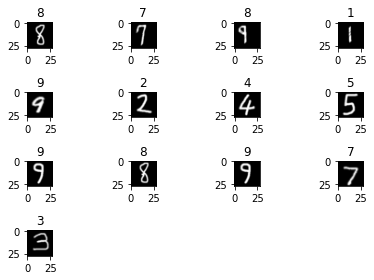

In [5]:
model = CNN().to(device)
model.load_state_dict(torch.load('mnist_model.pth', map_location = device))
model.eval()
n_image = len(digit_files)
ncols = 4
nrows = np.int(np.ceil(n_image/ncols))

for i, (x,f) in enumerate(my_test_dataloader):
    x = x.to(device)
    _,pred = model(x).max(-1)
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(x[0,0].to('cpu').numpy(),cmap='gray')
    plt.title(pred[0].item())

plt.tight_layout()

## predict a sigle image

In [11]:
def predict(model,img):
    model.eval()
    
    if type(model) is CNN:
        img_tensor = transform_test(img).unsqueeze(0).to(device) # (1,28,28)
    else:
        img_tensor = transform_test(img).reshape(-1, 28*28).to(device) # (1,28,28)

    _,pred = model(img_tensor).max(-1)
    return pred[0]

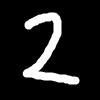

In [12]:
#path = 'seven2.png'
#path = 'eight.png'
#path = 'seven.png'
#path = 'three.png'
#path = 'five.png'
#path = 'my_digit4.png'
path = 'my_digit2.png'
#path = 'mnist_digit.png'
# img = Image.open(path).convert('L').resize((28, 28))
# img_tensor = transform(img).reshape(-1,28*28)


img = Image.open(path)
#img = Image.fromarray(drawing_image)
img

In [13]:
predict(model,img)

tensor(2)

In [14]:
if type(model) is CNN:
    img_tensor = transform_test(img).unsqueeze(0).to(device) # (1,28,28)
else:
    img_tensor = transform_test(img).reshape(-1, 28*28).to(device) # (1,28,28)


model(img_tensor)

tensor([[-16.1592,  -0.1211,  53.6910,   5.0860, -25.4025, -48.2006, -34.3265,
           6.1174,  -1.5220, -17.2006]], grad_fn=<AddmmBackward>)

In [ ]:
# 흑백으로 (28,28)로 resize된 이미지로 저장하기
tr = transforms.Grayscale(num_output_channels=1)(img)
tr = transforms.Resize((28,28))(tr)
temp = np.array(tr).astype(np.uint8)  #, img_tensor.shape
print(temp.dtype)
np.savetxt('mnist_digit.txt',temp,fmt='%i')
im = Image.fromarray(temp)
im.save("resized_mnist_fig.png")
im

## Drawing

In [15]:
import cv2
from PIL import Image
import numpy as np
import ctypes

prediction:  4


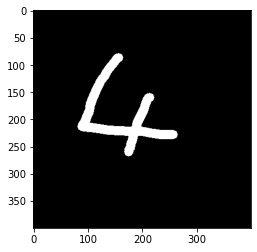

In [17]:
# creating a 600 x 600 pixels canvas for mouse drawing
canvas = np.ones((600,600), dtype="uint8") * 255
# designating a 400 x 400 pixels point of interest on which digits will be drawn
canvas[100:500,100:500] = 0

start_point = None
end_point = None
is_drawing = False

def draw_line(img,start_at,end_at):
    cv2.line(img,start_at,end_at,255,15)

def on_mouse_events(event,x,y,flags,params):
    global start_point
    global end_point
    global canvas
    global is_drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        if is_drawing == False:
            is_drawing=True
            start_point = (x,y)
    elif event == cv2.EVENT_MOUSEMOVE:
        if is_drawing:
            end_point = (x,y)
            draw_line(canvas,start_point,end_point)
            start_point = end_point
    elif event == cv2.EVENT_LBUTTONUP:
        is_drawing = False


cv2.namedWindow("Test Canvas")
cv2.setMouseCallback("Test Canvas", on_mouse_events)


while(True):
    cv2.imshow("Test Canvas", canvas)
    key = cv2.waitKey(1) & 0xFF 
    if key == ord('c'):
        canvas[100:500,100:500] = 0
    elif key == ord('d'):
        drawing_image = canvas[100:500,100:500]
        break
        #result = net.predict(image)
        #print("PREDICTION : ",result)

cv2.destroyAllWindows()
plt.imshow(drawing_image,cmap='gray')

draw_image=Image.fromarray(drawing_image)
pred = predict(model,draw_image).item()

ctypes.windll.user32.MessageBoxW(0, str(pred), "Prediction", 0)
print('prediction: ', pred)

## Drawing2: 이미지를 입력받아 파일로 저장(clear후 반복 저장 가능)

In [18]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import os
width = 200
height = 200
center = height//2
white = (255, 255, 255)
black = (0,0,0)
green = (0,128,0)

def save():
    j=0
    filename = "image" + str(j) + ".png"
    
    while os.path.exists(filename):
        j += 1
        filename = "image" + str(j) + ".png"
    image1.save(filename)

def clear():
    cv.delete("all")
    global image1, draw
    image1 = PIL.Image.new("RGB", (width, height), black)  # 저장되는 backgroudn color
    draw = ImageDraw.Draw(image1)
    
    

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    cv.create_oval(x1, y1, x2, y2, fill="white",width=20)  # 저장되는 color
    draw.line([x1, y1, x2, y2],fill="white",width=20)

root = Tk()

# Tkinter create a canvas to draw on
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()


image1 = PIL.Image.new("RGB", (width, height), black)  # 저장되는 backgroudn color
draw = ImageDraw.Draw(image1)



cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

button1=Button(text="save",command=save, width=10, height=2)
button2=Button(text="clear",command=clear, width=10, height=2)
button1.pack(side='left',anchor='s')  # left --> south ---> 왼쪽 아래
button2.pack(side='right',anchor='s') # 오른쪽 아래.

root.mainloop()